<a href="https://colab.research.google.com/github/RITIK-12/HAR/blob/main/Notebooks/MLinComm_Xethru_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

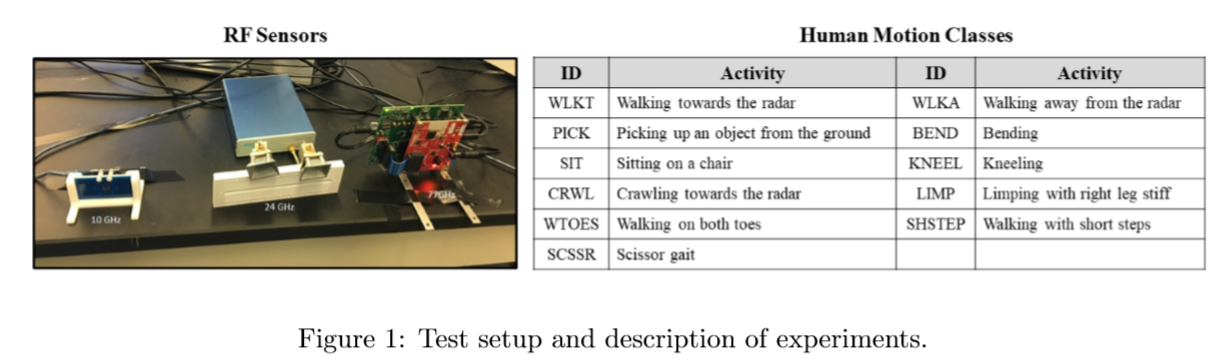

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
!mkdir /content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/spectogram_Xethru_split_data

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/spectogram_Xethru", output="/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/spectogram_Xethru_split_data",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False) # default values

Copying files: 735 files [03:51,  3.17 files/s]


In [ ]:
train_dir = '/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/spectogram_Xethru_split_data/train/'
train_dir = pathlib.Path(train_dir)
test_dir = '/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/spectogram_Xethru_split_data/test/'
test_dir = pathlib.Path(test_dir)
valid_dir = '/content/drive/MyDrive/RFSensorBasedHumanActivityRecognition/Spectograms_77_24_Xethrue/spectogram_Xethru_split_data/val/'
valid_dir = pathlib.Path(valid_dir)

In [ ]:
batch_size = 16
img_height = 128
img_width = 128

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 510 files belonging to 11 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 142 files belonging to 11 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  )

Found 83 files belonging to 11 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['05_Walking towards the radar', '06_Walking away from radar', '07_ picking up an object', '08_bending', '09_sitting', '10_kneeling', '11_crawling', '16_walking on both toes', '17_limping with right leg stiff', '18_short Step', '19_scissor Gait']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 128, 128, 3)
(16, 11)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
efnet = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet', input_shape=(128, 128,3),pooling='max')
output = efnet.layers[-1].output
#output = tf.keras.layers.Flatten()(output)
resnet = Model(efnet.input, output)

71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
efnet.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0

In [ ]:
for layer in resnet.layers:
  set_trainable = True

In [ ]:
num_classes = 11

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()

In [ ]:
filepath = "/content/drive/MyDrive/ITU/models/EfnetB4__Xethru_GHz_20Epochs.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_accuracy", 
    verbose=0, save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 5*1e-12,
                                   )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1792)              17673823  
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 11)                5643      
                                                                 
Total params: 20,040,298
Trainable params: 19,915,091
No

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    steps_per_epoch=np.ceil(float(510)/float(batch_size)), 
    epochs = 20,callbacks= callbacks, 
    validation_steps=np.ceil(float(142)/float(batch_size)), 
    use_multiprocessing= True
    )

Epoch 1/20
32/32 [==============================] - 19s 597ms/step - loss: 1.6662 - accuracy: 0.4294 - val_loss: 2.3745 - val_accuracy: 0.1408 - lr: 1.0000e-04
Epoch 2/20
32/32 [==============================] - 19s 594ms/step - loss: 1.0958 - accuracy: 0.6373 - val_loss: 2.2721 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 3/20
32/32 [==============================] - 19s 610ms/step - loss: 0.7705 - accuracy: 0.7471 - val_loss: 2.0474 - val_accuracy: 0.3380 - lr: 1.0000e-04
Epoch 4/20
32/32 [==============================] - 19s 597ms/step - loss: 0.5411 - accuracy: 0.8078 - val_loss: 2.0406 - val_accuracy: 0.3451 - lr: 1.0000e-04
Epoch 5/20
32/32 [==============================] - 19s 611ms/step - loss: 0.3922 - accuracy: 0.8569 - val_loss: 1.7597 - val_accuracy: 0.4789 - lr: 1.0000e-04
Epoch 6/20
32/32 [==============================] - 19s 606ms/step - loss: 0.2932 - accuracy: 0.8961 - val_loss: 1.4630 - val_accuracy: 0.5634 - lr: 1.0000e-04
Epoch 7/20
32/32 [======================

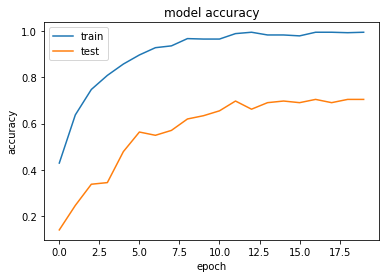

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

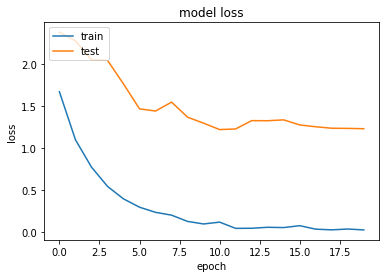

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

6/6 [==============================] - 1s 92ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]

2

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)
classes = class_names

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

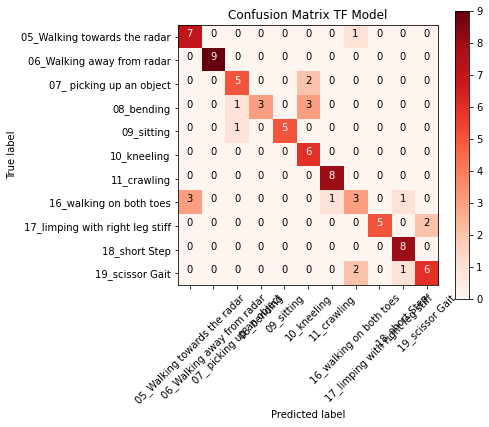

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('cm_wo_norm.png')
plt.show()

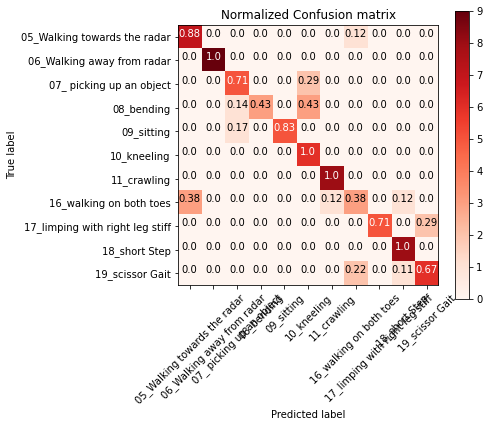

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('cm_norm.jpg')
plt.show()

In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report)

                                 precision    recall  f1-score   support

   05_Walking towards the radar       0.70      0.88      0.78         8
     06_Walking away from radar       1.00      1.00      1.00         9
       07_ picking up an object       0.71      0.71      0.71         7
                     08_bending       1.00      0.43      0.60         7
                     09_sitting       1.00      0.83      0.91         6
                    10_kneeling       0.55      1.00      0.71         6
                    11_crawling       0.89      1.00      0.94         8
        16_walking on both toes       0.50      0.38      0.43         8
17_limping with right leg stiff       1.00      0.71      0.83         7
                  18_short Step       0.80      1.00      0.89         8
                19_scissor Gait       0.75      0.67      0.71         9

                       accuracy                           0.78        83
                      macro avg       0.81      0